In [55]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

from run import Run
from runs_db import db as runs_db

In [57]:
log_path = '/home/fiit/logs'
runs = []

for server in runs_db:
    paths = glob.glob(os.path.join(log_path, server, '*'))
    paths = iter(sorted(paths))

    try:
        for (number, type_, code) in runs_db[server]:
            for _ in range(number):
                try:
                    path = next(paths)
                    runs.append(Run(path, type_, code))
                except KeyError:
                    print(path)
    except StopIteration:
        pass


/home/fiit/logs/deepnet2070/2019-03-29-050040


In [58]:
tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

task_metr = {
    'dep': 'uas',
    'lmo': 'perplexity',
    'ner': 'chunk_f1',
    'pos': 'acc'
}

task_max = {
    'dep': True,
    'lmo': False,
    'ner': True,
    'pos': True
}

def draw_graphs(metric_func, tasks, langs, role, run_codes=None, run_types=None):
    fig, axes = plt.subplots(len(tasks), len(langs), figsize=(5*len(langs), 4*len(tasks)), squeeze=False)

    relevant_runs = ['vanilla']

    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):

                history = run.history(
                    metric=metric_func(task),
                    task=task,
                    language=lang,
                    role=role)
                # axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.code}-{run.type}')
                axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.name}')

    for ax, col in zip(axes[0], langs):
        ax.set_title(col)

    for ax, row in zip(axes[:, 0], tasks):
        ax.set_ylabel(row, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()
    
def find_runs(run_code=None, run_type=None, contains=None, **hparams):
    
    if contains is None:
        contains = []
    
    return (run
           for run
           in runs
           if  (run_code is None or run_code == run.code) and
               (run_type is None or run_type == run.type) and
               all(run.contains(*task_lang) for task_lang in contains) and
               all(run.hparams[key] == value for key, value in hparams.items()))
    
    
def print_results(runs, tasks, langs, metric_func=None, metric_max_func=None, print_lambda=None):
    
    if print_lambda is None:
        print_lambda = lambda val, run: print(f'{val:.2f}')
        
    if metric_func is None:
        metric_func = lambda task: task_metr[task]
        
    if metric_max_func is None:
        metric_max_func = lambda task: task_max[task]
        
    output = []
    
    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            res, epoch = run.metric_eval(
                metric=metric_func(task),
                max_=metric_max_func(task),
                task=task,
                language=lang)
            if res < 1.01:
                res *= 100
            print_lambda(res, run)
            output.append((res, epoch, run))
                
    return output

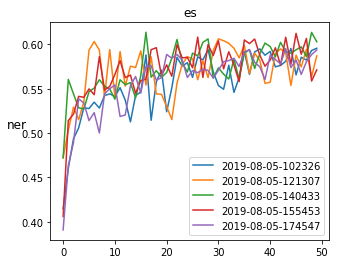

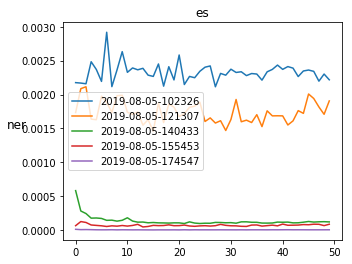

59.48
60.32
61.34
61.24
59.41


[(59.48368590892793, 39, <run.Run at 0x7f3b9b32edd8>),
 (60.31689513975432, 7, <run.Run at 0x7f3b8fefe4e0>),
 (61.34080052709603, 49, <run.Run at 0x7f3b9b1bfcf8>),
 (61.23530385825469, 46, <run.Run at 0x7f3b974f9048>),
 (59.40832473340213, 37, <run.Run at 0x7f3b9c51f908>)]

In [60]:
code = 'zero-shot7'
task = 'ner'
lang = 'es'
draw_graphs(lambda t: task_metr[t], [task], [lang], 'test', run_codes=[code])
draw_graphs(lambda t: 'ortho', [task], [lang], 'test', run_codes=[code])
print_results(find_runs(run_code=code), [task], [lang], lambda t: task_metr[t], lambda t: task_max[t])

In [ ]:
# baseline
for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    run = next(find_runs('vanilla', 'stsl', [(t, l)]))
    print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
print()

# print best pair
# print avg pair
print('88.79 79.78 84.93 86.70 78.77 83.07 85.07 87.69 99.04 94.59 96.14 96.86')
print('88.27 79.65 84.52 86.36 78.06 82.12 84.64 86.73 98.96 94.51 96.07 96.63')

# print MT

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private-focused', 'mt', [(t, l)], focus_on=f'{t}-{l}'))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# print ML

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private-focused', 'ml', [(t, l)], focus_on=f'{t}-{l}'))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# print MTML

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private-focused-0.75', 'mtml', [(t, l)], focus_on=f'{t}-{l}'))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# print MT 0.25

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private', 'mt', [(t, l)]))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# print ML 0.25

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private', 'ml', [(t, l)]))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# print MT 0.75

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private-focused-0.75', 'mt', [(t, l)], focus_on=f'{t}-{l}'))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# print ML 0.75

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private-focused-0.75', 'ml', [(t, l)], focus_on=f'{t}-{l}'))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

# TOP 3
print('89.04 79.75 85.00 86.87 78.86 82.18 84.57 87.06 99.04 -0.01 96.05 96.65')

# TOP 1

for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('private-focused', 'top1', [(t, l)], focus_on=f'{t}-{l}'))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

for code in ['no-adv-tsh-2000', 'no-adv-tsh-200']:
    for type_ in ['mt', 'ml', 'mtml']:
        for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
            try:
                run = next(find_runs(code, type_, [(t, l)], limited_task_language=f'{t}-{l}'))
                print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
            except StopIteration:
                print('-0.01 ', end='')
        print()


for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('vanilla-2000', 'stsl', [(t, l)]))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()
        
for t, l in itertools.product(['dep', 'ner', 'pos'], langs):
    try:
        run = next(find_runs('vanilla-200', 'stsl', [(t, l)]))
        print_results([run], [t], [l], print_lambda=lambda val, run: print(f'{val:.2f}', end=' '))
    except StopIteration:
        print('-0.01 ', end='')
print()

In [ ]:
txt = """89.16 79.93 84.92 86.51 78.10 81.36 84.96 86.77 98.89 94.19 95.99 96.46 
88.79 79.78 84.93 86.70 78.77 83.07 85.07 87.69 99.04 94.59 96.14 96.86
88.27 79.65 84.52 86.36 78.06 82.12 84.64 86.73 98.96 94.51 96.07 96.63
88.44 79.87 84.81 86.48 77.40 83.03 84.73 86.46 99.04 94.45 96.05 96.72 
89.04 79.75 84.76 86.87 78.24 81.43 84.70 86.61 98.96 94.65 96.10 96.69 
89.39 80.47 84.98 86.57 77.45 82.67 84.84 86.79 99.04 94.57 96.04 96.75 
87.98 79.94 84.41 86.33 77.67 81.85 84.70 87.13 98.89 94.51 96.16 96.73 
88.19 79.73 84.94 86.38 78.15 82.34 84.87 86.60 98.88 94.57 95.98 96.74 
88.90 -0.01 -0.01 86.69 77.82 -0.01 -0.01 86.27 99.05 -0.01 -0.01 96.53 
89.60 -0.01 -0.01 86.62 78.00 -0.01 -0.01 86.18 99.05 -0.01 -0.01 96.71 
89.04 79.75 85.00 86.87 78.86 82.18 84.57 87.06 99.04 -0.01 96.05 96.65
88.65 79.54 84.89 86.69 78.15 -0.01 85.09 86.27 99.01 94.45 96.02 96.80 
79.90 -0.01 -0.01 81.45 75.25 -0.01 -0.01 83.07 98.05 -0.01 -0.01 96.20 
79.60 -0.01 -0.01 82.07 74.25 -0.01 -0.01 84.49 97.52 -0.01 -0.01 95.62 
80.27 -0.01 -0.01 82.75 74.31 -0.01 -0.01 83.53 97.91 -0.01 -0.01 96.15 
69.47 -0.01 -0.01 71.89 65.05 -0.01 -0.01 79.29 97.18 -0.01 -0.01 95.50 
67.96 -0.01 -0.01 72.81 66.67 -0.01 -0.01 80.38 94.65 -0.01 -0.01 94.26 
71.12 -0.01 -0.01 74.04 66.10 -0.01 -0.01 81.24 97.01 -0.01 -0.01 95.54 
78.02 -0.01 -0.01 80.82 73.10 -0.01 -0.01 81.74 97.18 -0.01 -0.01 95.20 
62.57 -0.01 -0.01 67.82 53.47 -0.01 -0.01 74.37 92.88 -0.01 -0.01 92.44 
""".strip()

import statistics as stats

data = []
for i, line in enumerate(txt.split('\n')):
    data.append([])
    for cell in line.split():
        data[i].append(float(cell))
    data[i] = [data[i][j] for j in [0, 3, 4, 7, 8, 11]]
        
        
erdc = []
for line in data[1:]:
    erdc.append([])
    for j, cell in enumerate(line):
        if cell >= 0:
            erdc[-1].append((cell - data[-1][j]) / (100 - data[-1][j]))
        else:
            erdc[-1].append(None)

def print_mean_std(data):
    print(f'& {stats.mean(data)*100:.2f}\pm{stats.stdev(data)*100:.2f}', end='')

#erdc = [erdc[i] for i in [10, 1, 2, 3, 4, 9]] 
#erdc = [erdc[i] for i in [2,3,5,6,7,8]] 
erdc = [erdc[i] for i in [2,3,4,11,12,13,14,15,16]] 

tags = ['Best pairs', 'Avg pairs', 'Cross-T', 'Cross-L', 'Cross-L-T', 'Top 3']
for i, l in enumerate(erdc):
    #print(f'\\textbf{{{tags[i]}}}', end=' ')
    #for slc in [slice(0, 4), slice(4, 8), slice(8, 12)]:
    #for slc in [slice(0, 2), slice(2, 4), slice(4, 6)]:
    for slc in [slice(0, 6)]:
        d = [i for i in l[slc] if i is not None]
        print_mean_std(d)
    print(' \\\\')
    

In [ ]:
for run in find_runs(run_type="top3"):
    focus = run.hparams['focus_on']
    task, lang = focus.split('-')
    print(focus)
    print_results([run], [task], [lang])

In [ ]:

pair_runs = [run for run in runs if run.code == 'one-aux']
for task, lang in itertools.product(['dep', 'ner', 'pos'], ['cs', 'de', 'en', 'es']):
    results = []
    for r in pair_runs:
        if r.contains(task, lang):
            score, _ = r.metric_eval(task_metr[task], task_max[task], task=task, language=lang)
            l = list(r.hparams['tasks'])
            l.remove((task, lang))
            results.append((score, l[0]))
    print(task, lang)
    print(sorted(results, key=lambda x: -x[0])[:3])

In [ ]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['sk'],
    print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))
print()
print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['sk'],
    print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

In [ ]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['cs'],
     ['private-focused-0.75'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['es'],
     ['private-focused'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['ner'], ['cs'],
     ['vanilla'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('87.69 /home/fiit/logs/acer/2019-02-22-025619')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['cs'],
     ['no-adv-tsh-focused-0.75'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['es'],
     ['no-adv-tsh-focused'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print()

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['de'],
     ['private'], ['mt'], lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
     ['private'], ['ml'], lambda val, run: print(f'{val:.2f} {run.path}'))

print('83.07 /home/fiit/logs/deepnet2/2019-02-26-041529')
print('85.07 /home/fiit/logs/acer/2019-02-20-213852')

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['de'],
     ['vanilla'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

print_results(lambda task: task_metr[task], lambda task: task_max[task], ['pos'], ['en'],
     ['private'], ['mt'], print_lambda=lambda val, run: print(f'{val:.2f} {run.path}'))

In [ ]:
# draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
#              ['private-focused-200', 'no-adv-tsh-200'], ['ml'])
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
             ['vanilla', 'no-mwe'], ['ml'])

In [ ]:
pairs = [('dep','cs'), ('dep','es'), ('ner','cs'), ('ner','es'), ('pos','cs'), ('pos','es'),]

def print_row(code, type_):
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))

codes = ['private-focused', 'no-adv-tsh-focused']
types = ['ml', 'mt']

print('baseline 89.16 86.51 78.10 86.77 98.89 96.46')
print('best unfocused 89.16 86.70 81.58 87.69 99.04 96.87')


for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75']
types = ['ml', 'mt']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()
        
codes = ['private-focused-0.75', 'no-adv-tsh-focused-0.75', 'private-focused', 'no-adv-tsh-focused']
types = ['mtml']

for code in codes:
    for type_ in types:
        print(f'{code}{type_}', end='\t\t')
        print_row(code, type_)
        print()


# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.25'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['dep-adv-lambda-0.125'])
# print_results(lambda task: task_metr[task], lambda task: task_max[task], ['dep'], ['en'],
#             ['no-adv-task-sharing'], ['ml'])

In [ ]:
import numpy as np

pairs = list(itertools.product(['dep', 'ner', 'pos'], langs))

def print_row(code, type_, msg):
    print(msg, end=' ')
    for t, l in pairs:
        print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                    [code], [type_], lambda val, run: print(f'{val:.2f}', end=' '))
    print()
        
print_row('vanilla', 'stsl', 'Baseline')

print('Best1', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

print('Avg', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{np.mean([r[0] for r in output]):.2f}', end=' ')
print()


print('Worst1', end=' ')
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    print(f'{min([r[0] for r in output]):.2f}', end=' ')
print()

print_row('vanilla', 'mt', 'A-MT')
print_row('no-adv-task-sharing', 'ml', 'A-ML')
print_row('no-adv-task-sharing', 'mtml', 'A-MTML')
print_row('private', 'mt', 'B-MT')
print_row('private', 'ml', 'B-ML')
print_row('private', 'mtml', 'B-MTML')
print_row('no-adv', 'ml', 'C-ML')
print_row('no-adv', 'mtml', 'C-MTML')

In [ ]:
for t, l in pairs:
    output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [t], [l],
                ['one-aux'], print_lambda=lambda _, __: ...)
    output = sorted(output, key=lambda r: -r[0])
    print(output[0][1].hparams['tasks'])
    #print(f'{max([r[0] for r in output]):.2f}', end=' ')
print()

In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test', ['vanilla'])

In [ ]:
print_results(lambda task: task_metr[task], lambda task: task_max[task], tasks, langs,
     ['fine-tune'], print_lambda=lambda val, run: print(f'{val:.2f} {run.hparams["train_only"]}'))

In [ ]:
def yield_results(task, lang):
    
    code_types = [
        ('vanilla-200', 'stsl'),
        ('vanilla-2000', 'stsl'),
        ('vanilla', 'stsl'),
        ('no-adv-tsh-200', 'mt'),
        ('no-adv-tsh-2000', 'mt'),
        ('vanilla', 'mt'),
        ('no-adv-tsh-200', 'ml'),
        ('no-adv-tsh-2000', 'ml'),
        ('no-adv-task-sharing', 'ml'),
        ('no-adv-tsh-200', 'mtml'),
        ('no-adv-tsh-2000', 'mtml'),
        ('no-adv-task-sharing', 'mtml'),

        
    ]
    
    for code, type_ in code_types:

        output = print_results(lambda task: task_metr[task], lambda task: task_max[task], [task], [lang],
         [code], [type_], print_lambda=lambda val, run: ...)
        for res, run in output:
            if run.hparams['limited_task_language'] in [f'{task}-{lang}', None]:
                yield res

fig, axes = plt.subplots(1, 6, figsize=(20, 3), squeeze=False)

sizes = {
    ('dep', 'cs'): 67900,
    ('dep', 'es'): 14000,
    ('ner', 'cs'): 7100,
    ('ner', 'es'): 6900, 
    ('pos', 'cs'): 67900,  
    ('pos', 'es'): 14000,
}

titles = {
    ('dep', 'cs'): 'DP-cs',
    ('dep', 'es'): 'DP-es',
    ('ner', 'cs'): 'NER-cs',
    ('ner', 'es'): 'NER-es', 
    ('pos', 'cs'): 'POS-cs',  
    ('pos', 'es'): 'POS-es',    
}

for i, (t, l) in enumerate(itertools.product(['dep', 'ner', 'pos'], ['cs', 'es'])):
    results = list(yield_results(t, l))
    axes[0, i].plot([200,2000,sizes[t, l]], results[0:3])
    axes[0, i].plot([200,2000,sizes[t, l]], results[3:6])
    axes[0, i].plot([200,2000,sizes[t, l]], results[6:9])  
    axes[0, i].plot([200,2000,sizes[t, l]], results[9:12])
    axes[0, i].set_xscale('log')
    axes[0, i].set_xticks([200,2000,sizes[t, l]])
    axes[0, i].set_xticklabels(['200', '2000', 'full'])
    axes[0, i].set_title(titles[t, l])
    axes[0, i].set_xlabel('train size')

    
axes[0,0].set_ylabel('performance')
    

#           ax.set_title(col)

#     for ax, row in zip(axes[:, 0], tasks):
#         ax.set_ylabel(row, rotation=0, size='large')
        
#     for ax_row in axes:
#         for ax in ax_row:
#             ax.legend()
  

# for ax, col in zip(axes[0], langs):
#     ax.set_title(col)

# for ax, row in zip(axes[:, 0], tasks):
#     ax.set_ylabel(row, rotation=0, size='large')

# for ax_row in axes:
#     for ax in ax_row:
#         ax.legend()

plt.savefig('sample.pdf')
plt.show()



